# ニューラルネットワークを用いた手書き文字認識

今回の演習では，ニューラルネットワークを利用した手書き文字認識を作成してみます．近年の研究では複雑なニューラルネットワークを大規模データを利用して学習することで，非常に高い制度で文字認識を行うことができます．今回の演習では，講義で学習した3層の基本的なニューラルネットワークを利用して，ニューラルネットワークがどのように文字認識を行っているかを確認してみます．

# 0. 今回利用する Python(numpy) の機能

今回の演習で利用する Python の機能について説明します，プログラミングの詳細に興味がない場合は1まで飛ばしてください（ビデオでの説明もありません）

## ベクトルの要素積（アダマール積）

ベクトルの要素積は以下のようにベクトル同士を掛けあわせることで計算できます．
今回は行ベクトル $ x = [1, 2, 3, 4, 5]$ を使って計算してみます．

In [2]:
# 0-1: ベクトルの要素積（アダマール積）

import numpy as np

x = np.array([[1,2,3,4,5]])
print("x * x = ", x * x)

x * x =  [[ 1  4  9 16 25]]


# スカラーとベクトルの計算
ベクトルとスカラーを足し合わせることで，すべての要素に値を足すことが可能です．

In [ ]:
# 0-2: ベクトルとスカラーの足し算

print("x + 1 = ", x + 1)

ベクトルでスカラーを割った場合も，要素ごとの割り算を行うことができます．

In [ ]:
# 0-3: ベクトルとスカラーの割り算

print("5.0 / x =", 5.0/x)

行列，ベクトルの転置は x.T と記述することで，計算可能です．行ベクトルx は x.T により列ベクトルとなります．同様に，列ベクトルは行ベクトルになります．

In [ ]:
# 0-4: ベクトルの転置

print("x^T = ", x.T)

ベクトル・行列の一般的な積は @ で計算可能です．例えば，xどうしの内積(x,x)は以下で計算可能です．

In [ ]:
# 0-5: 行列・ベクトルの積

print("(x,x) = ", x @ x.T)

exp(x), 平方根などもまとめて計算可能です．

In [ ]:
# 0-6: いろいろな計算

print("exp(x) =", np.exp(x))
print("sqrt(x) = ", np.sqrt(x))

以上を踏まえてニューラルネットの学習を実装してみます．

# 1. 画像のデータの表現
手書き文字認識を実施するにあたり，手書き文字などの画像データがどのように表現されるか考えてみます．まずは，実際に手動（マウス）で文字を書いてみて，それがどのように表現されるか見てみましょう．

入力した画像は以下のとおりです
 [[  0.   0.  31.  40.  37.   4.   0.   0.]
 [  1. 131. 247. 254. 244. 138.   0.   0.]
 [  4. 123. 148. 102. 221. 197.   0.   0.]
 [  0.   0.   0.   6. 230. 178.   0.   0.]
 [  0.   0.   3. 146. 255.  71.   0.   0.]
 [  0.   1. 154. 255. 160.   0.   0.   0.]
 [  0.   2. 170. 255. 229. 160.  62.   0.]
 [  0.   0.   6.  92. 186. 255. 116.   0.]]
グラフで表すとこうなります（列ベクトルで見づらいため，転置して行ベクトルとして表示しています）



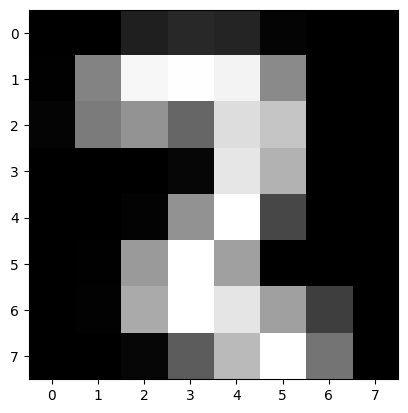

ベクトルで表現するとこうなります

x^T =  [[  0.   0.  31.  40.  37.   4.   0.   0.   1. 131. 247. 254. 244. 138.
    0.   0.   4. 123. 148. 102. 221. 197.   0.   0.   0.   0.   0.   6.
  230. 178.   0.   0.   0.   0.   3. 146. 255.  71.   0.   0.   0.   1.
  154. 255. 160.   0.   0.   0.   0.   2. 170. 255. 229. 160.  62.   0.
    0.   0.   6.  92. 186. 255. 116.   0.]]


In [5]:
#@title 左の矢印（▷）を押して，下に表示される黒い枠の中にマウスで数字を書いてみてください．書き終わったら finish ボタンを押してください．

from IPython.display import HTML
from io import BytesIO
from PIL import Image as Im
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import matplotlib.pyplot as plt

canvas_html = """
<canvas width=%d height=%d></canvas>
<br>
<button>Finish</button>
<button id="clear">Clear</button>

<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
ctx.fillStyle = 'rgb(0,0,0)';
ctx.fillRect(0, 0, canvas.width, canvas.height);
ctx.strokeStyle = 'white';

var button = document.querySelector('button')
var mouse = {x: 0, y: 0}



canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

clear.addEventListener("click", function(){
  ctx.fillStyle = 'rgb(0,0,0)';
  ctx.fillRect(0, 0, canvas.width, canvas.height);
});

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

width = 8
height = 8

def draw(filename='drawing.png', w=160, h=160, line_width=30):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  img = Im.open(BytesIO(binary))
  img = img.resize((width,height))
  img = img.convert('L')

  return np.array(img,dtype=np.float64)

x = draw()
print("入力した画像は以下のとおりです\n", x)
N = x.shape[1] * x.shape[0]
print("グラフで表すとこうなります（列ベクトルで見づらいため，転置して行ベクトルとして表示しています）\n")
plt.imshow(x, cmap="gray")
plt.show()
print("ベクトルで表現するとこうなります\n")
x = x.reshape([N,1])
print("x^T = ", x.T)


上記の通り，画像は小さなマス目に区切られており，それぞれのマス目（今回は8x8=64個のマス目）に明るさ（輝度）を設定することで構成されています．この明るさを数値により表現し，これを並べてベクトルとすることで解析が行われます．

## 1.1 データの正規化

しかし，画像をそのまま扱った場合，画像を取得した状況に応じてデータのばらつきが生じてしまいます．例としてノートに書かれた数字をカメラで撮影する場合を考えてみます．このような場合，たとえ同じ数字を撮影した場合でも，部屋が明るい場合には全体的に明るい画像（輝度が高い画像）が，暗い場合には暗い画像（輝度が低い画像）が撮影されることになります．このような明るさの影響によるデータのばらつきを抑制するための処理がデータの正規化です．データの正規化には様々な方法がありますが，明るさの平均が0, 分散が1となるように正規化してみます．このような正規化は，以下の式で実現できます．

$ 平均：E(x) = \frac{1}{N}\sum_{j=1}^N x_i = {\bf 1}^T {\bf x} / N$

$ 分散：\sigma^2 = E(x^2) - E(x)^2 = \frac{1}{N}\sum_{j=1}^N x_j^2 - E(x)^2 = {\bf x}^T {\bf x} / N - E(x)^2 $

$ 正規化された画像：{\bf x}' = (x_i - E(x))/\sqrt{\sigma^2}$

ここで，${\bf x} = [x_1, x_2, \cdots, x_N]^T$, $N$はマス目の個数（今回は64）です．

### 問題１：このような正規化操作を実現するための関数を作成してみましょう

In [6]:
# 1-1: データの正規化

def normalize(x):
  one = np.ones(N) # one はすべての要素が1のベクトルです

  ave = np.mean(x) # 問題１−１：平均の計算
  var = np.var(x) # 問題１−２：分散の計算

  x_d = (x - ave) / np.sqrt(var) # 問題１−３：正規化されたベクトル x_d を計算
  return x_d

# 値がどのように変化するか表示してみます．
print("正規化前")
print(x.T)
print("正規化後")
print(normalize(x).T)

正規化前
[[  0.   0.  31.  40.  37.   4.   0.   0.   1. 131. 247. 254. 244. 138.
    0.   0.   4. 123. 148. 102. 221. 197.   0.   0.   0.   0.   0.   6.
  230. 178.   0.   0.   0.   0.   3. 146. 255.  71.   0.   0.   0.   1.
  154. 255. 160.   0.   0.   0.   0.   2. 170. 255. 229. 160.  62.   0.
    0.   0.   6.  92. 186. 255. 116.   0.]]
正規化後
[[-0.81305433 -0.81305433 -0.48478819 -0.38948512 -0.42125281 -0.77069741
  -0.81305433 -0.81305433 -0.8024651   0.57413482  1.80248552  1.87661013
   1.77071783  0.64825943 -0.81305433 -0.81305433 -0.77069741  0.48942098
   0.75415173  0.26704715  1.52716554  1.27302401 -0.81305433 -0.81305433
  -0.81305433 -0.81305433 -0.81305433 -0.74951895  1.62246861  1.07182864
  -0.81305433 -0.81305433 -0.81305433 -0.81305433 -0.78128664  0.73297327
   1.88719936 -0.06121899 -0.81305433 -0.81305433 -0.81305433 -0.8024651
   0.81768712  1.88719936  0.8812225  -0.81305433 -0.81305433 -0.81305433
  -0.81305433 -0.79187587  0.9871148   1.88719936  1.61187938  0.88

このような正規化を施すことで，文字識別を安定化させることができます．

## 1.2 手書き数字データセットの読み込み

文字認識を行うニューラルネットを構成するためには，手書き文字画像を大量に集める必要があります．今回はPython上にあらかじめ準備されたデータセットを利用します．
ここでは下のプログラムを実行してください（変更箇所はありません）．

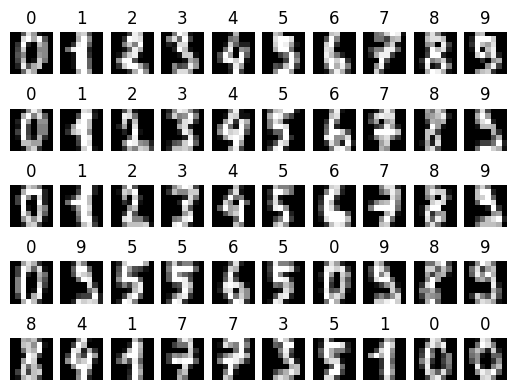

画像の総数は 1797 です．


In [7]:
# 1-2: 手書き数字データの読み込み
import matplotlib.pyplot as plt

from sklearn import datasets
digits = datasets.load_digits()
labels = digits.target
images = digits.images
# 10 個分のデータを表示する
for i in range(50):
  plt.subplot(5, 10, i+1)
  plt.axis("off")
  plt.title(str(labels[i]))
  plt.imshow(images[i], cmap="gray")

plt.show()
print("画像の総数は", images.shape[0], "です．")


# 2. ニューラルネットの作成と学習
## 2.1 ベクトル・行列による表現

それでは，実際にニューラルネットワークの構成と学習を行っていきます．ニューラルネットの構成は講義資料に則って行いますが，ここではpythonによる実装を簡単にするためにベクトル・行列の表現を用いてそれぞれの計算を以下のように書き換えます（式の意味は同じです）．

$ {\bf u}_i = {\bf w}_0 + W{\bf x}_i $

$ {\bf z}_i = \psi({\bf u})_i$

$ \hat{y}_i = v_0 + {\bf v}^T {\bf z}_i$


ここで，${\bf u}_i$, ${\bf z}_i$，${\bf v}$，${\bf w}_0$，$W$, は以下のとおりです．

${\bf u}_i = [u_{1i}, \cdots, c_{Ni}]^T$

${\bf z}_i = [z_{1i}, \cdots, z_{Ni}]^T$

${\bf v} = [v_{1i}, \cdots, v_{Ki}]^T$

$ {\bf w}_0 = [w_{01}, \cdots, w_{0N}]^T$

$W =
\left [
\begin{array}{ccc}
w_{11} & \cdots & w_{1N}\\
& \ddots & \\
w_{K1} & \cdots & w_{KN}
\end{array}
\right ]
$

$K$は中間層のノードの数です．

$\hat{y}_i$がニューラルネット全体の出力であり，今回はこの出力が画像に描かれた数字と一致するようにニューラルネットを学習します．例えば画像に書かれた文字が3であったとすれば，3に近い数字が出力されるように学習を行います．ここでは，画像に描かれた数字が教師データ$y_i$として得られているとし，$\hat{y}_i$と$y_i$により誤差$E$を以下のように定義します．

$E = \sum_{i=1}^K (y_i - \hat{y}_i)^2 = \sum_{i=1}^K e_i^2$

講義資料のとおり，ニューラルネットの学習はこの誤差$E$を最小とする${\bf v}$, $v_0$，$W$, ${\bf w}_0$を求めることに相当します．

まずは，これらの値を入れておくための行列，ベクトルを準備します（ひとまず変更箇所はありません）．

In [16]:
# 2-1: データの初期化，中間層のノード数を変更する場合は以下を変更して実行

K = 30 # 中間層のノード数

# 入力層と中間層の接続に関するパラメタ
w0 = np.random.rand(K,1)
W = np.random.rand(K, N)

# 中間層と出力層の接続に関するパラメタ
v = np.random.rand(K,1)
v0 = np.random.rand()

これらの行列ベクトルにはひとまずランダムな値を入れておき，これを学習により最適化していきます．

## 2.2 非線形関数

次に，非線形関数としてシグモイド関数を準備します．講義資料にあるとおりシグモイド関数は以下のように定義されています．

$\psi(z) = \frac{1}{1+\exp(-z)}$

### 問題２：シグモイド関数を作成してください．

In [9]:
# 2-2: 非線形関数（シグモイド関数）

def sigmoid(z):
  psi = 1 / (1 + np.exp(-z)) # 問題２：psi(z) の計算結果を psi に代入します．
  return psi

## 2.3 順方向計算の作成

再度の記述となりますが，$\hat{y}_i$は以下のように計算されます．

$ {\bf u}_i = {\bf w}_0 + W{\bf x}_i $

$ {\bf z}_i = \psi({\bf u})_i$

$ \hat{y}_i = v_0 + {\bf v}^T {\bf z}_i$


### 問題３：それではこれらを使ってまず順伝播（入力${\bf x}_i$から$\hat{y}_i$を計算するプロセス）を作成しましょう．

In [10]:
# 2-3: 順方向の計算

def forward_prop(v0, v, w0, W, x_i):
  u_i = w0 + W @ x_i # 問題３−１：入力 x_i から u_i を計算
  z_i = sigmoid(u_i) # 問題３−２：シグモイド関数により z_iを計算
  yh_i = v0 + v.T @ z_i # 問題３−３：yh_i を計算

  return yh_i, z_i

このようにして得られる$\hat{y_i}$と与えられたラベル$y_i$との差分により評価関数$E_i$が計算されます．この$E$を最小化することで，ニューラルネットの学習が行われます．以降の2.4から2.6についてはこの$E$を最小化する，誤差逆伝播法と呼ばれる方法です．**今回は説明を割愛しますので，2.4，2.5の ▷ ボタンを押して2.6まで進んでください．▷ ボタンを押さない場合，以降のプログラムが動きませんので注意してください．**また，興味がある人は各自で確認してください．

## 2.4 逆方向計算の作成

次に，評価関数$E$の偏微分結果を逆方向に反映させていくことで，それぞれの変数の勾配を計算してみます．

この計算では，$\frac{\partial E}{\partial W}$など，$E$の各変数についての偏微分を計算する必要がありますが，これらは以下のように$\frac{\partial e_i}{\partial W}$の総和として計算できます．

$ \frac{\partial E}{\partial W} = \sum_{i=1}^n \frac{\partial e_i}{\partial W}$

$ \frac{\partial E}{\partial {\bf v}} = \sum_{i=1}^n \frac{\partial e_i}{\partial {\bf v}}$

そのため，まずは$e_i$の各変数についての偏微分を計算します．講義資料のとおり，これらは以下のように計算できます．

$\frac{\partial e_i}{\partial v_0} = -2 (y_i - \hat{y}_i)$

$\frac{\partial e_i}{\partial {v}_k} = -2 (y_i - \hat{y}_i) z_{ik}$

これは，以下のようにまとめることができます．

$
\frac{\partial e_i}{\partial {\bf v}} =
\left [
\begin{array}{c}
\frac{\partial e_i}{\partial {v}_1} \\
\vdots \\
\frac{\partial e_i}{\partial {v}_K}
\end{array}
\right ]
=
\left [
\begin{array}{c}
\frac{\partial e_i}{\partial v_0} z_{i1}\\
\vdots\\
\frac{\partial e_i}{\partial v_0} z_{iK}
\end{array}
\right ]
= \frac{\partial e_i}{\partial v_0} {\bf z}_i
$

また，${w}_{k0}$については以下のように計算できます．

$ \frac{\partial e_i}{\partial w_{k0}} = -2 (y_i - \hat{y}_i) v_k \psi(u_{ik}) (1 - \psi(u_{ik})) = \frac{\partial e_i}{\partial {v}_k}v_k(1-z_{ik})$

これは以下のようにまとめられます．

$
\frac{\partial e_i}{\partial {\bf w}_0} =
\left [
  \begin{array}{c}
  \frac{\partial e_i}{\partial w_{10}} \\ \vdots \\ \frac{\partial e_i}{\partial w_{K0}}
  \end{array}
\right ]
=
\left [
  \begin{array}{c}
  \frac{\partial e_i}{\partial {v}_1}v_1(1-z_{i1}) \\ \vdots \\
  \frac{\partial e_i}{\partial {v}_K}v_K(1-z_{iK})
  \end{array}
\right ]
 = \frac{\partial e_i}{\partial {\bf v}} \circ {\bf v} \circ ({\bf 1} - {\bf z})
$

ここで，$\circ$はベクトルの要素ごとの積を表します．

同様に${w}_{kj}$についても以下のように計算できます．

$ \frac{\partial e_i}{\partial w_{kj}} = -2 (y_i - \hat{y}_i) v_k \psi(u_{ik}) (1 - \psi(u_{ik}))x_{ij} = \frac{\partial e_i}{\partial w_{k0}}x_{ij}$

これは，以下のようにまとめることができます．

$\frac{\partial e_i}{\partial W} =
\left [
\begin{array}{ccc}
\frac{\partial e_i}{\partial w_{11}} & \cdots & \frac{\partial e_i}{\partial w_{1N}}\\
&  \ddots & \\
\frac{\partial e_i}{\partial w_{K1}} & \cdots & \frac{\partial e_i}{\partial w_{KN}}
\end{array}
\right ]
=
\left [
  \begin{array}{ccc}
  \frac{\partial e_i}{\partial {\bf w}_0} x_{i1} &
  \cdots &
  \frac{\partial e_i}{\partial {\bf w}_0} x_{iN}
  \end{array}
\right ] =
\frac{\partial e_i}{\partial {\bf w}_0} {\bf x}_i^T
$

以上をまとめると，$e_i$の各変数についての偏微分は以下のように計算できます．

$
\frac{\partial e_i}{\partial \hat{y}_i} = -2 (y_i - \hat{y}_i)\\
\frac{\partial e_i}{\partial v_0} = \frac{\partial e_i}{\partial \hat{y}_i}\\
\frac{\partial e_i}{\partial {\bf v}} = \frac{\partial e_i}{\partial v_0} {\bf z}_i\\
\frac{\partial e_i}{\partial {\bf w}_0} = \frac{\partial e_i}{\partial {\bf v}} \circ {\bf v} \circ ({\bf 1} - {\bf z}_i)\\
\frac{\partial e_i}{\partial W} =
\frac{\partial e_i}{\partial {\bf w}_0} {\bf x}_i^T
$


In [11]:
# 2-4: 逆方向の計算（誤差逆伝播）

def back_prop(yh_i, y_i, v, z_i, x_i,):
  # yh_i：ニューラルネットの出力，y_i：教師ラベル（正解の数値）
  # v, z_i, x_i：中間層のベクトル，中間層の出力，入力画像
  dy_i =  -2 * (y_i - yh_i) #de_i / dy_i
  dv0_i = dy_i            # de_i / dv_0# de_i / dv_0
  dv_i =  dv0_i * z_i     # de_i / dv
  dw0_i = dv_i * v * (1-z_i)   # de_i / dw0
  dW_i =  dw0_i @ x_i.T        # de_i / dW

  return dv0_i, dv_i, dw0_i, dW_i

## 2.5 $E$に関する微分の計算

これで，$i$番目の画像に対する評価値$e_i$の各変数についての偏微分を計算することができました．次はこれらの総和を計算することで，全体の評価関数$E$に対する勾配を計算してみましょう．


In [12]:
# 2-5: 評価関数全体の微分の計算

def derivative_E(images, labels, data_num, v0, v, w0, W):
  # 微分の累積を 0 にセット
  dv0 = 0
  dv = np.zeros([K,1])
  dw0 = np.zeros([K,1])
  dW = np.zeros([K, N])

  for i in range(data_num):
    # 画像をベクトルに変形
    x_i = np.array(images[i],dtype=np.float64).reshape(N,1)
    # 正規化
    x_i = normalize(x_i)
    # ラベルを取得
    y_i = labels[i]
    # 順方向計算（先ほど作成した関数により計算）
    yh_i, z_i = forward_prop(v0, v, w0, W, x_i)
    # 逆方向計算（先ほど作成した関数により計算）
    dv0_i, dv_i, dw0_i, dW_i = back_prop(yh_i, y_i, v, z_i, x_i)

    dv0 = dv0 + dv0_i # dv0_i の総和から dv0を計算
    dv =  dv + dv_i   # dv の総和から dv を計算
    dw0 = dw0 + dw0_i # dw0_i の総和から dw0 を計算
    dW =  dW + dW_i   # dW_i の総和から dW を計算

  return dv0, dv, dw0, dW

## 2.6 性能チェック機能の作成

これで，ニューラルネットの学習を行うための準備が整いました．これからこれらを利用して繰り返し計算によりニューラルネットワークの学習を行っていきます．ただし，このような学習を行う場合，どこまで学習がすすんだかを確認するため，ニューラルネットの状態をチェックするための機能が必要となります．そこで，現在のパラメタ($v_o, {\bf v}, {\bf w}_0, W)$と画像データから誤差の総和および現在の認識率（数字が正しく認識される割合）を計算する関数を作成します．

In [13]:
# 2-6: 性能チェック関数

def neuralnet_exam(images, labels, start, num, v0, v, w0, W):
  # ラベルと出力の2乗誤差の総和
  err = 0
  # 正しく識別あ行われた総数
  correct = 0

  for i in range(start, start + num):
    x_i = normalize(np.array(images[i],dtype=np.float64).reshape(N,1))
    yh_i, z_i = forward_prop(v0, v, w0, W, x_i)
    err += (yh_i - labels[i])**2
    if (abs(labels[i] - yh_i) < 0.5):
      correct+=1
  return err, correct

これで，現在の学習状態をチェックすることが可能となりました．

# 3 ニューラルネットの学習とテスト

## 3.1 学習プログラムの作成
それでは，$W$等のパラメタを微分値を用いて更新することで，ニューラルネットの学習を行いましょう．講義資料にあるとおり，これらのパラメタは以下のように更新されます．

$
\left [
  \begin{array}{c}
  {v_0^{t+1}} \\ {\bf v}^{t+1} \\ {\bf w}_0^{t+1} \\ W^{t+1}
  \end{array}
\right ]=
\left [
  \begin{array}{c}
  {v_0^{t}} \\ {\bf v}^{t} \\ {\bf w}_0^{t} \\ W^{t}
  \end{array}
\right ]
  -
\alpha_t
\left [
  \begin{array}{c}
  \frac{\partial E}{\partial v_0^{t}} |_{(W, {\bf v}) = (W^t, {\bf v}^t)} \\
  \frac{\partial E}{\partial {\bf v^{t}}} |_{(W, {\bf v}) = (W^t, {\bf v}^t)}\\
  \frac{\partial E}{{\partial \bf w}_0^{t}} |_{(W, {\bf v}) = (W^t, {\bf v}^t)} \\
  \frac{\partial E}{\partial W^{t}}|_{(W, {\bf v}) = (W^t, {\bf v}^t)}
  \end{array}
\right ]
$

$\alpha_t$は更新に応じて変更する方法などもありますが，今回は固定の値として0.1/（学習に用いるデータの数）を利用します（データ数で割っている理由は，データの数が大きくなると，微分の総和も大きくなるためです）．
### 問題４：下記のプログラムのパラメタ更新部分を作成して実行することで，どのように学習が進むか確認してみましょう（5000回のパラメタ更新を行うため，プログラムの実行には数分かかります，学習終了が表示されるまで待ってください）

In [17]:
# 3-1: ニューラルネットの学習

# 学習に用いるデータの数
data_num = 1000

# 更新のステップ幅（学習率などとも呼ばれる）
alpha = 0.1 / data_num
# 繰り返し回数，今回は5000回
T = 5000
num = int(T/100)

# 誤差の変化を記録しておくための配列
err_train = np.zeros(num,dtype=np.float64)
err_test = np.zeros(num,dtype=np.float64)
cor_train = np.zeros(num,dtype=np.float64)
cor_test = np.zeros(num,dtype=np.float64)

for t in range (T):
  err = 0
  correct = 0
  num = int(T/100)

  # 各パラメタの微分を計算
  dv0, dv, dw0, dW = derivative_E(images, labels, data_num , v0, v, w0, W)

  # 問題６：alpha と微分結果を使って各パラメタを更新しましょう（足し算ではなく引き算になることに注意してください）
  v0 = v0 - alpha * dv0# 問題６−１：v0をalphaとdv0を使って更新
  v = v - alpha * dv # 問題６−２：vをalphaとdvを使って更新
  w0 = w0 - alpha * dw0 # 問題６−３：w0をalphaとdw0を使って更新
  W = W - alpha * dW # 問題６−４：WをalphaとdWを使って更新

  # 100回に1回性能をチェック
  if ((t+1) % 100 == 0):
    # 訓練データでチェック
    p = int(t/100)
    err_train[p], cor_train[p] = neuralnet_exam(images, labels, 0, 100, v0, v, w0, W)
    # 検証用データでチェック
    err_test[p], cor_test[p] = neuralnet_exam(images, labels, 1000, 100, v0, v, w0, W)

    print("loop = ", t+1, "error = ",err_train[p], err_test[p],"accuracy = ", cor_train[p], cor_test[p])
print("学習が終了しました")

<ipython-input-17-ffbec818ec8a>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  err_train[p], cor_train[p] = neuralnet_exam(images, labels, 0, 100, v0, v, w0, W)
<ipython-input-17-ffbec818ec8a>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  err_test[p], cor_test[p] = neuralnet_exam(images, labels, 1000, 100, v0, v, w0, W)


loop =  100 error =  248.91701168510238 223.9609242621049 accuracy =  30.0 38.0
loop =  200 error =  179.86165427792798 181.76816142685726 accuracy =  35.0 46.0
loop =  300 error =  144.85733380851582 160.02189644548235 accuracy =  40.0 41.0
loop =  400 error =  114.18489022565339 145.79356803435604 accuracy =  43.0 42.0
loop =  500 error =  94.11002484059635 137.17124007351012 accuracy =  45.0 42.0
loop =  600 error =  79.90960405166808 132.84638895155325 accuracy =  46.0 46.0
loop =  700 error =  70.03772353096714 131.60580515535761 accuracy =  51.0 48.0
loop =  800 error =  62.88781228783479 132.294432205036 accuracy =  54.0 50.0
loop =  900 error =  57.282311085862794 134.03263938018785 accuracy =  56.0 48.0
loop =  1000 error =  52.66738794583228 136.07902374839415 accuracy =  57.0 48.0
loop =  1100 error =  48.762772082368876 138.01245172849792 accuracy =  63.0 49.0
loop =  1200 error =  45.39109016011075 139.705059135776 accuracy =  64.0 50.0
loop =  1300 error =  42.43086207890

学習が終了したら，下のプログラムを実行して誤差と識別率の遷移をグラフとして表示してみましょう（変更箇所はありません）

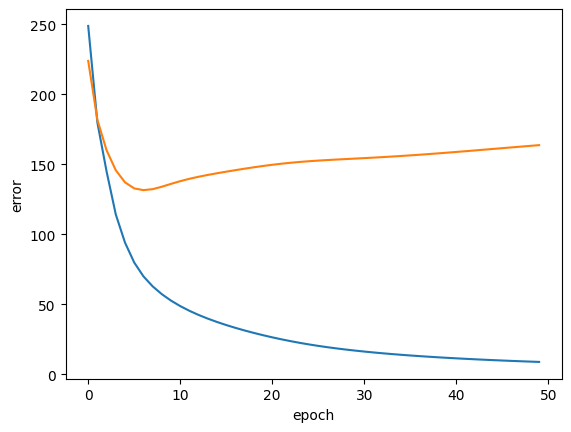

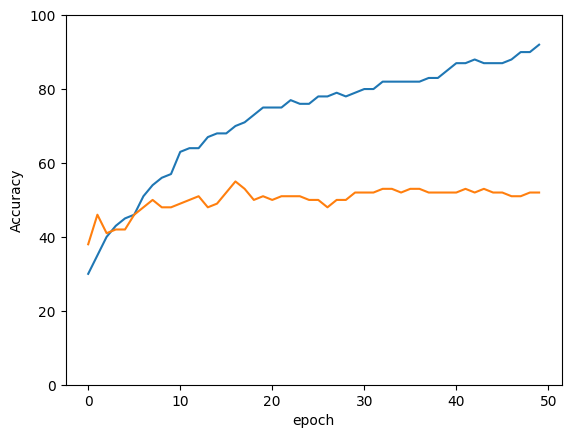

In [18]:
# 3-1-2: 学習遷移の表示

# 誤差の遷移を表示する
plt.figure()
plt.xlabel("epoch")
plt.ylabel("error")
plt.plot(np.arange(50), err_train)
plt.plot(np.arange(50), err_test)

# 認識率の遷移を表示する．
plt.figure()
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.ylim(0,100)
plt.plot(np.arange(50), cor_train)
plt.plot(np.arange(50), cor_test)

上を実行することで２つのグラフが表示されたはずです．１つ目のグラフは訓練データ（オレンジ），テストデータ（青）それぞれに対する誤差の遷移を表しており，グラフが下（0）に近づくほど誤差が小さくなっていることを表しています．もうひとつは識別性能の遷移を表しており，上（100%）に近づくほど高い性能を示しています．
グラフを見るとわかりますが，どちらのグラフについても訓練データよりもテストデータの方が悪い値となっていることがわかります．これは，ニューラルネットが訓練データに対して最適化されているため，これに含まれないデータに対しては性能が低下してしまうためです．このような現象は過学習と呼ばれます．これは，学習に用いるデータの数や学習するパラメタの数（中間層の層数やノード数）により変化しますが，一般的に学習データの数を増加させ，また，全体のパラメタ数を減少させることでその影響を軽減させられることがわかっています．

なお，上のプログラム（3-1）を再度実行することで，続きから学習を行うことができます．パラメタが十分に学習されていない場合はこれにより性能を高められることもありますが，パラメタの数（K）が大きい場合には過学習が発生しやすくなります．


## 3.2 パラメタ数の学習への影響

### 問題7：パラメタを変更しての再実行（下の手書き文字認識を実行したあとに行ってください）

それではパラメタの数を変化させてみて，実際に学習結果がどのように変化するか確認してみましょう．中間層のノード数は「2-1:データの初期化」のKの値で設定されていますので，これを異なる数字に変化させて再度学習を行ってみましょう（Kの値を変更したあと，順番に各ブロックを実行してください）．
なお，K=10（初期設定）の場合の結果も提出してもらいますので，再度学習を行う前にグラフと識別結果は撮影しておいてください．


# 4. 手書き文字認識

最後に実際にマウスで文字を書いて手書き文字認識を行ってみましょう

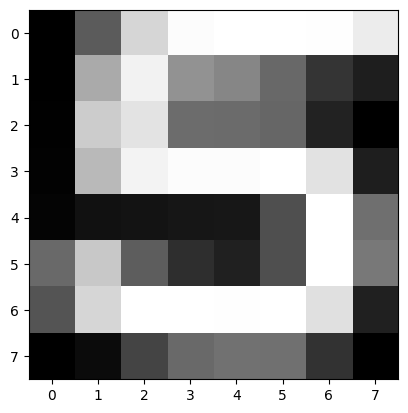

識別結果は [[4.13687762]] です


In [ ]:
#@title 左の矢印▷を押して出てくる四角にマウスで数字を書いて認識してみましょう（再実行したい場合は，再度▷を押してください）
canvas_html = """
<canvas width=%d height=%d></canvas>
<br>
<button>Finish</button>
<button id="clear">Clear</button>

<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
ctx.fillStyle = 'rgb(0,0,0)';
ctx.fillRect(0, 0, canvas.width, canvas.height);
ctx.strokeStyle = 'white';

var button = document.querySelector('button')
var mouse = {x: 0, y: 0}



canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

clear.addEventListener("click", function(){
  ctx.fillStyle = 'rgb(0,0,0)';
  ctx.fillRect(0, 0, canvas.width, canvas.height);
});

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

width = 8
height = 8

def draw2(filename='drawing.png', w=160, h=160, line_width=30):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  img = Im.open(BytesIO(binary))
  img = img.resize((width,height))
  img = img.convert('L')

  return np.array(img,dtype=np.float64)

x = draw()
plt.imshow(x, cmap="gray")
plt.show()
y_i, z_i = forward_prop(v0, v, w0, W, normalize(x.reshape(N,1)))
print("識別結果は",y_i,"です")

文字の下部にニューラルネットからの出力が表示されています．今回は，ニューラルネットからの出力が画像に書かれた数字に近くなるように学習が行われているため，書いた数字に近い値（例えば３を書いたとすれば，2.5 - 3.5 の実数）が出力されていれば適切に文字認識が行えていると言えます．

うまく認識できましたか？今回は非常に基本的な構造を持つニューラルネットワークを利用しているため，そこまで高い識別性能は実現できていません．しかし，現在はより高精度に認識を行うために様々な研究が行われており，非常に高い識別性能を持つニューラルネットワークも実現されています．興味があればそれらについても調べてみると良いでしょう．



お疲れ様でした，以上で今回の演習は終了です．以下の内容を提出してください．
1. K = 10 とした場合の誤差と正解率の遷移のグラフを撮影して提出してください．
2. K の値を 10 より小さい値（例えば5），10より大きい値（例えば20）のそれぞれに変化させ，それぞれの場合の誤差，正解率の遷移の変化を撮影して提出してください．提出する際に，Kの値を下記のレポートに記述してください
3. 2で利用したKの値とそれぞれの場合の結果について，なぜそのような結果になったか考察し，それをレポートに手書きしたものを撮影して提出してください．
